In [1]:
import pandas as pd
import numpy as np
import scipy as sci
import arch
import pyvinecopulib as pv
import matplotlib.pyplot as plt
import plotly.express as px
from SourceCodes.invariance_analysis import quick_invariance_analysis
from SourceCodes.garch_aux_methods import zero_mean_garch_1_1_scenario


columns_mappings = {'ES1 Index': 'SP500',
                    'NQ1 Index': 'Nasdaq100',
                    'VG1 Index': 'Euro Stox50',
                    'BZ1 Index': 'Ibovespa',
                    'TY1 Comdty':'10-Year Treasury',
                    'RX1 Comdty': 'Euro Bund',
                    'EC1 Curncy': 'EUR/USD',
                    'BP1 Curncy': 'GBP/USD',
                    'UC1 Curncy': 'USD/BRL',
                    'CL1 Comdty': 'WTI',
                    'CO1 Comdty': 'Brent'}

selected_securities = ['SP500', 'Nasdaq100', 'Ibovespa', '10-Year Treasury','USD/BRL']


In [2]:
# Reading data
df = pd.read_csv("Data/data.csv", index_col="Dates", date_parser = pd.to_datetime).rename(columns=columns_mappings)[selected_securities]
df.sort_index(inplace=True)
returns_scale_factor = 100
df_log_ret = np.log(df).diff() * returns_scale_factor
n = df.shape[0]
n_os = 252
n_scenarios = 1000
seeds = [int(x) for x in np.ones(len(selected_securities)).tolist()]

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\yuriv\.conda\envs\py37\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\yuriv\.conda\envs\py37\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


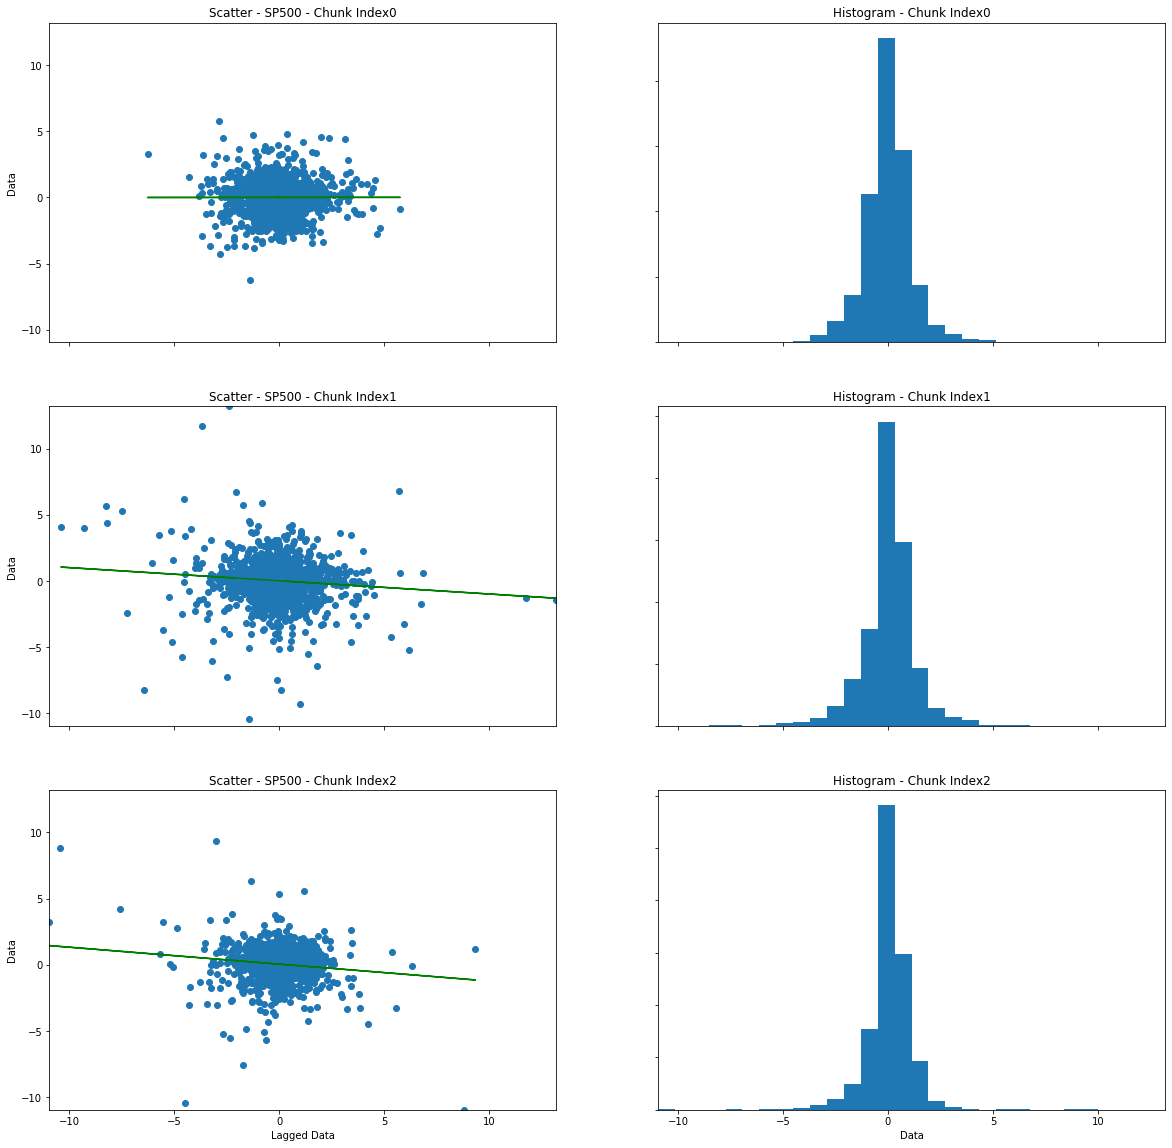

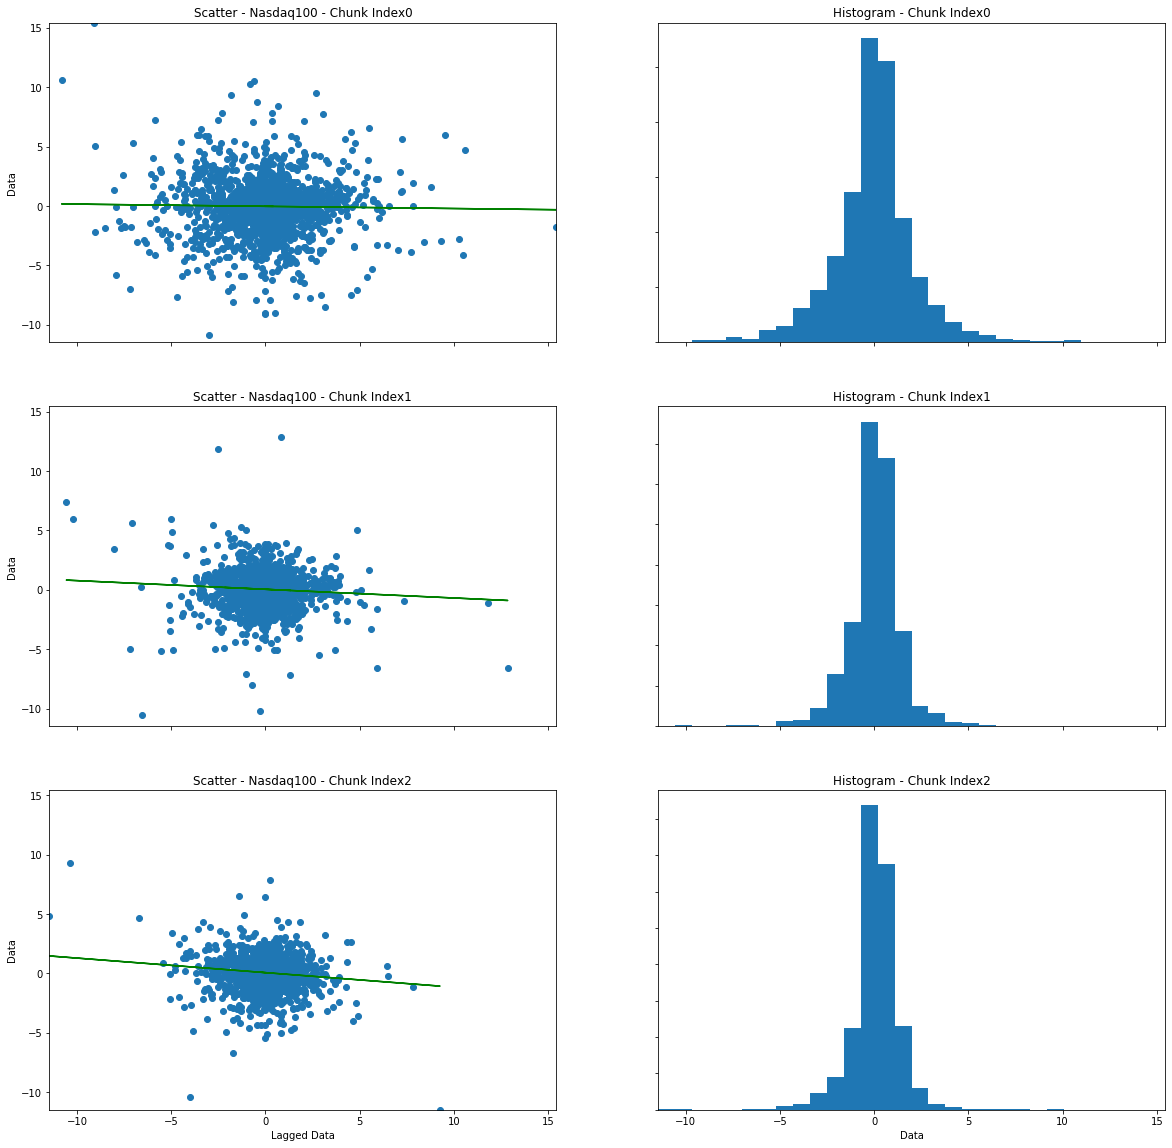

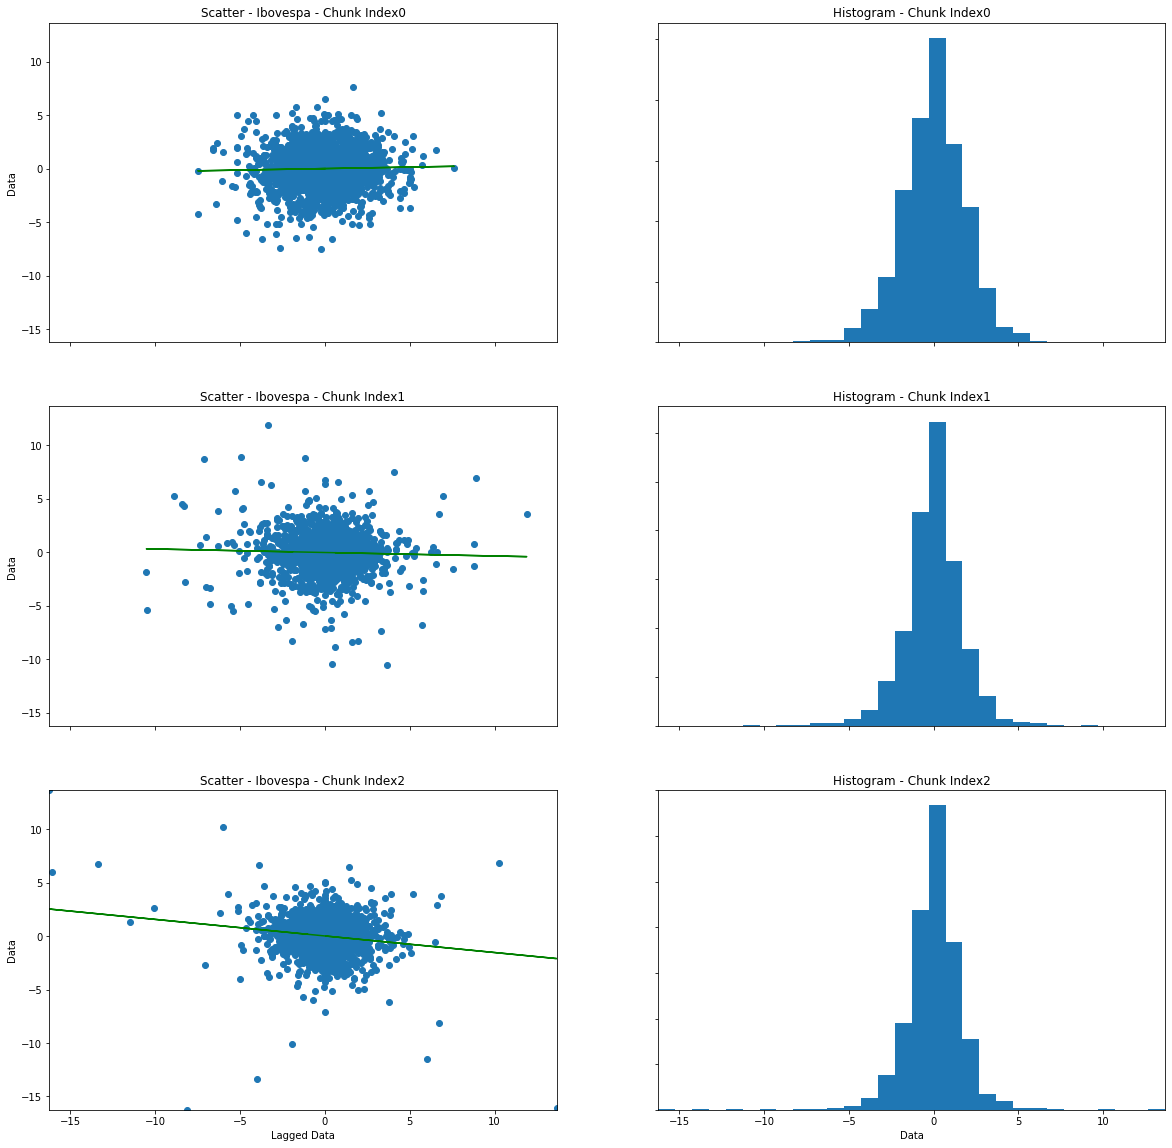

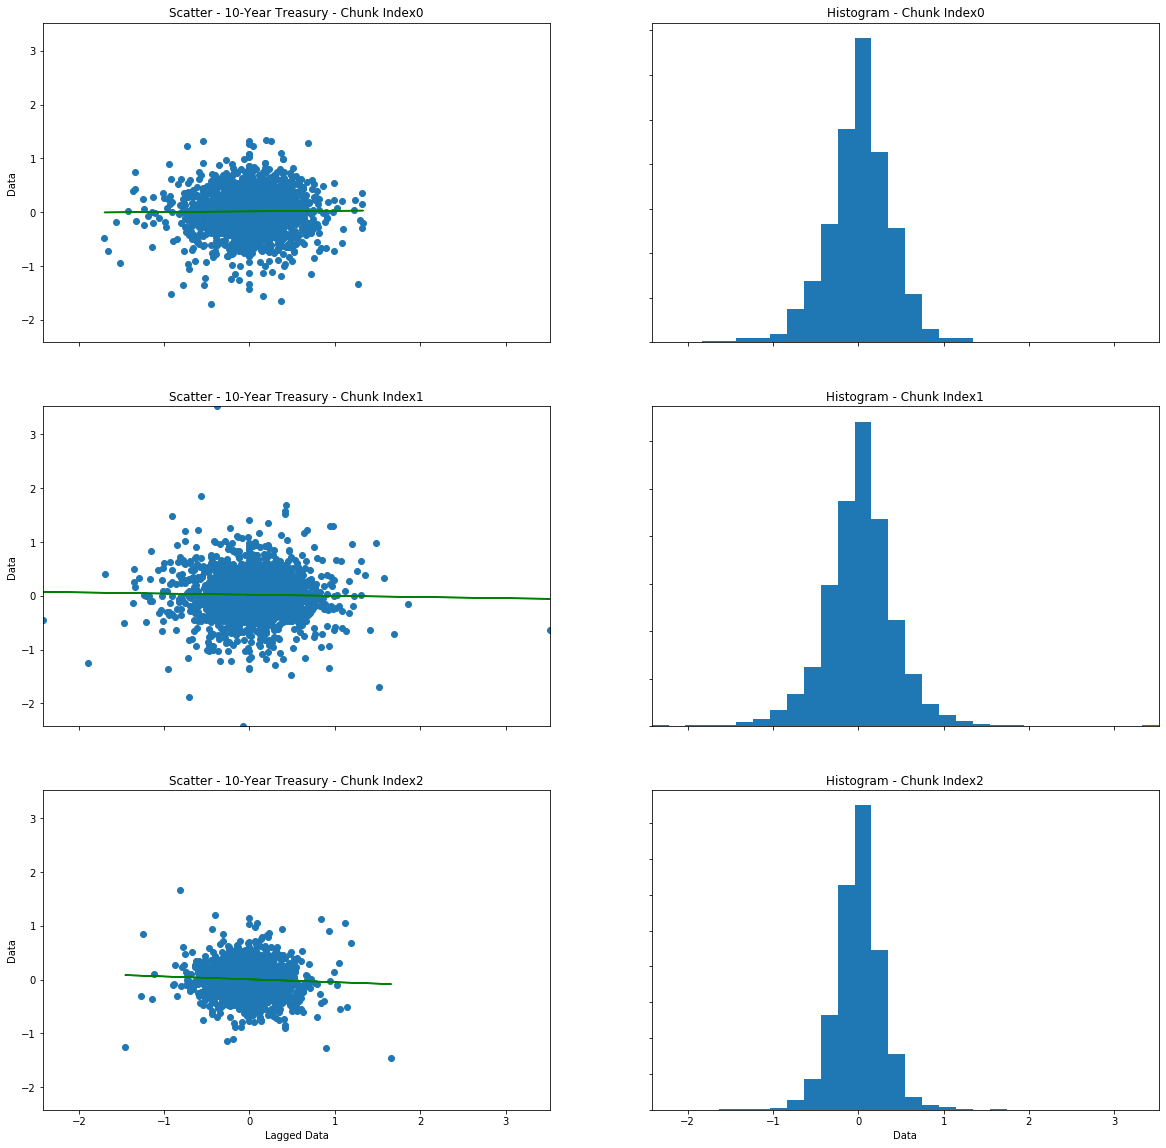

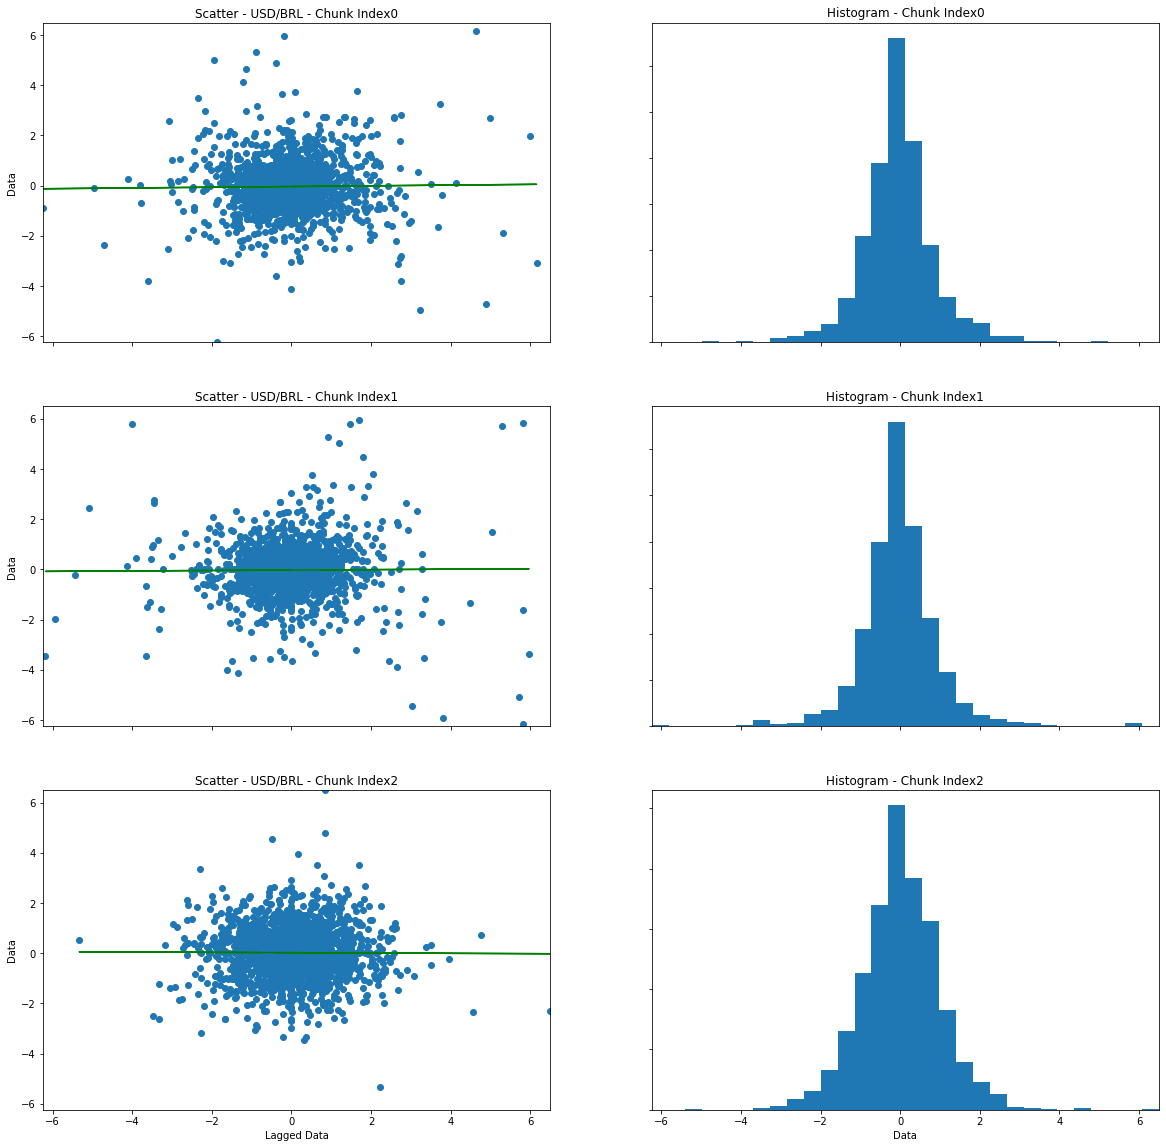

In [3]:
# Quick Invariance Analysis
for item in df_log_ret.columns:
    fig, axs = quick_invariance_analysis(df_log_ret[item].iloc[:-n_os], n_chunks=3, nbins=30)
    fig.set_size_inches(20, 20)

In [4]:
# Fitting a GARCH(1,1) Model and
model_list = []

for k, item in enumerate(df_log_ret):
    mdl = list()
    mdl.append(arch.arch_model(df_log_ret.iloc[1:-n_os, k] , mean="Zero", vol="GARCH", p=1, q=1, dist="t"))
    mdl.append(mdl[0].fit())
    model_list.append(mdl)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 80921.6397473279
Iteration:      2,   Func. Count:     13,   Neg. LLF: 14786.11984306161
Iteration:      3,   Func. Count:     20,   Neg. LLF: 13644.35091704398
Iteration:      4,   Func. Count:     26,   Neg. LLF: 7905.9483602634655
Iteration:      5,   Func. Count:     32,   Neg. LLF: 8353.746726049843
Iteration:      6,   Func. Count:     38,   Neg. LLF: 7857.592654900929
Iteration:      7,   Func. Count:     43,   Neg. LLF: 7854.489817698201
Iteration:      8,   Func. Count:     48,   Neg. LLF: 7852.765412268598
Iteration:      9,   Func. Count:     53,   Neg. LLF: 7852.1362442421905
Iteration:     10,   Func. Count:     58,   Neg. LLF: 7851.850075651737
Iteration:     11,   Func. Count:     63,   Neg. LLF: 7851.848743915597
Iteration:     12,   Func. Count:     68,   Neg. LLF: 7851.84868742069
Iteration:     13,   Func. Count:     72,   Neg. LLF: 7851.848687420694
Optimization terminated successfully    (Exit mode 0)
          

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\yuriv\.conda\envs\py37\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


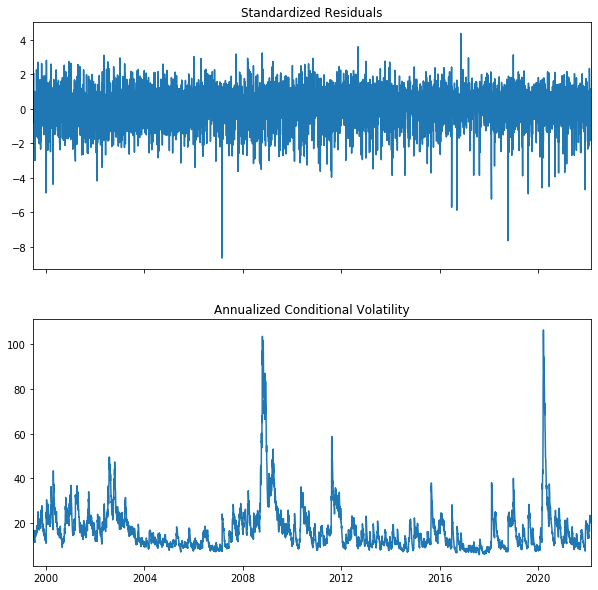

In [5]:
fig = model_list[0][1].plot(scale=252)
fig.set_size_inches(10, 10)

In [6]:
# Creating the matrix of residuals and scatter plotting
for k, item in enumerate(model_list):
    if k == 0:
        df_log_resid = pd.DataFrame(item[1].std_resid)
        df_log_resid.rename(columns={df_log_resid.columns[-1]:item[0].y.name}, inplace=True)
    else:
        df_log_resid = pd.concat([df_log_resid, pd.DataFrame(item[1].std_resid)], axis=1)
        df_log_resid.rename(columns={df_log_resid.columns[-1]:item[0].y.name}, inplace=True)

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


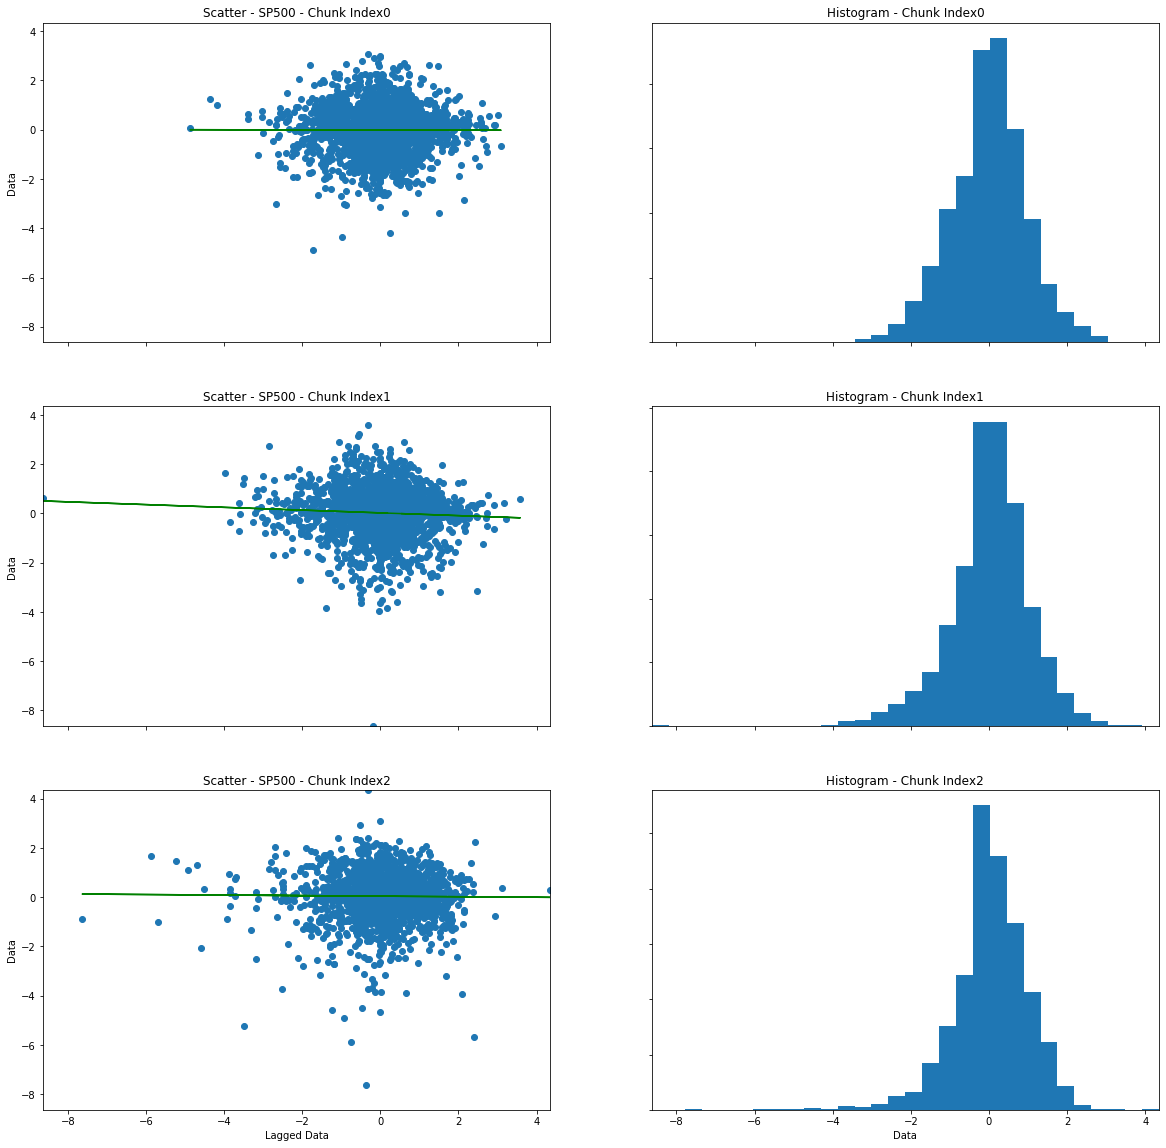

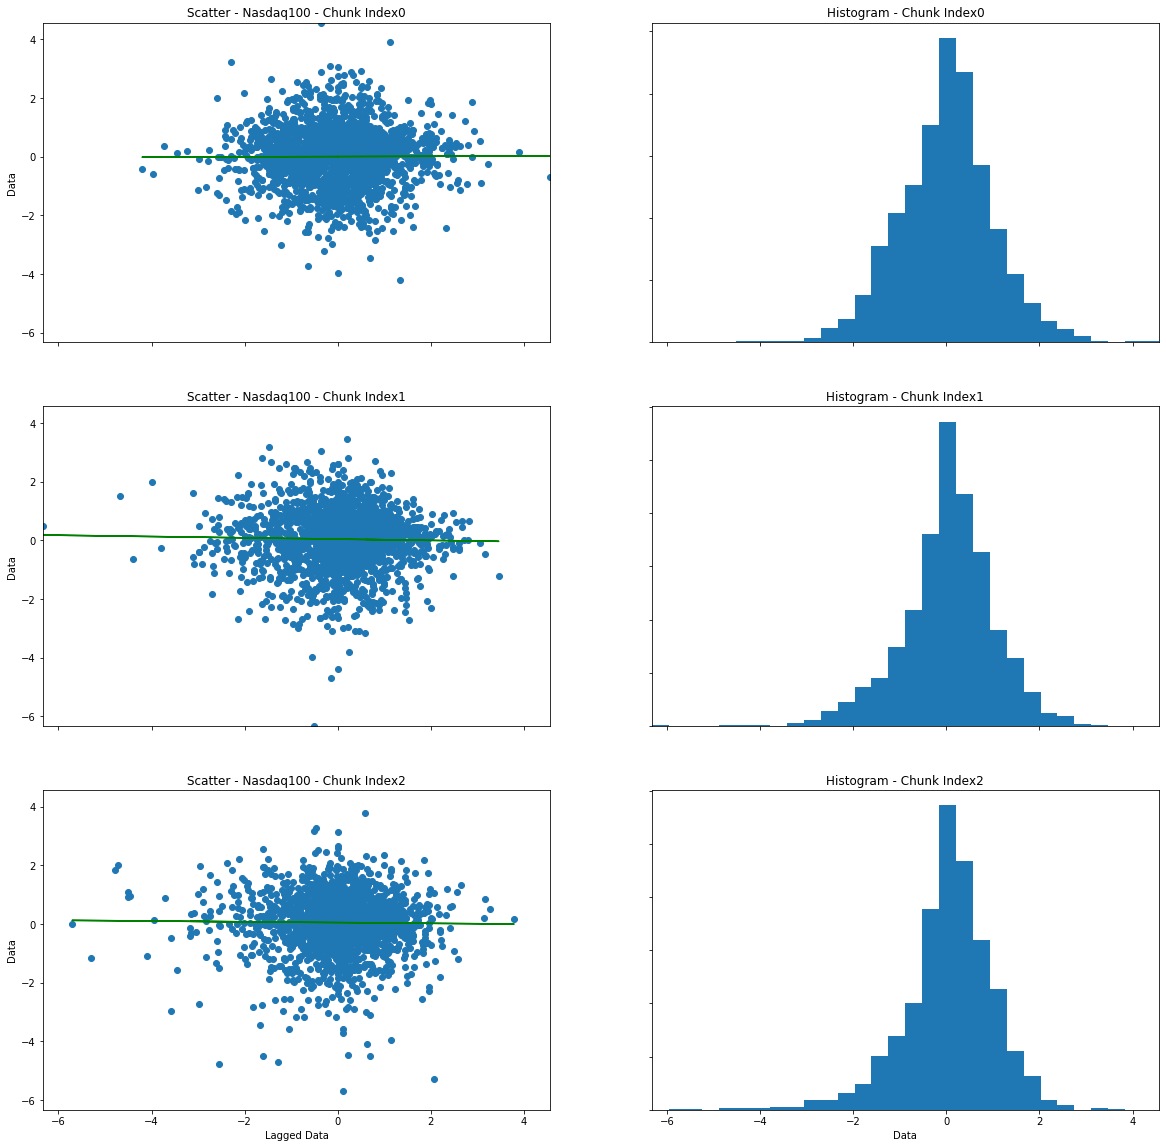

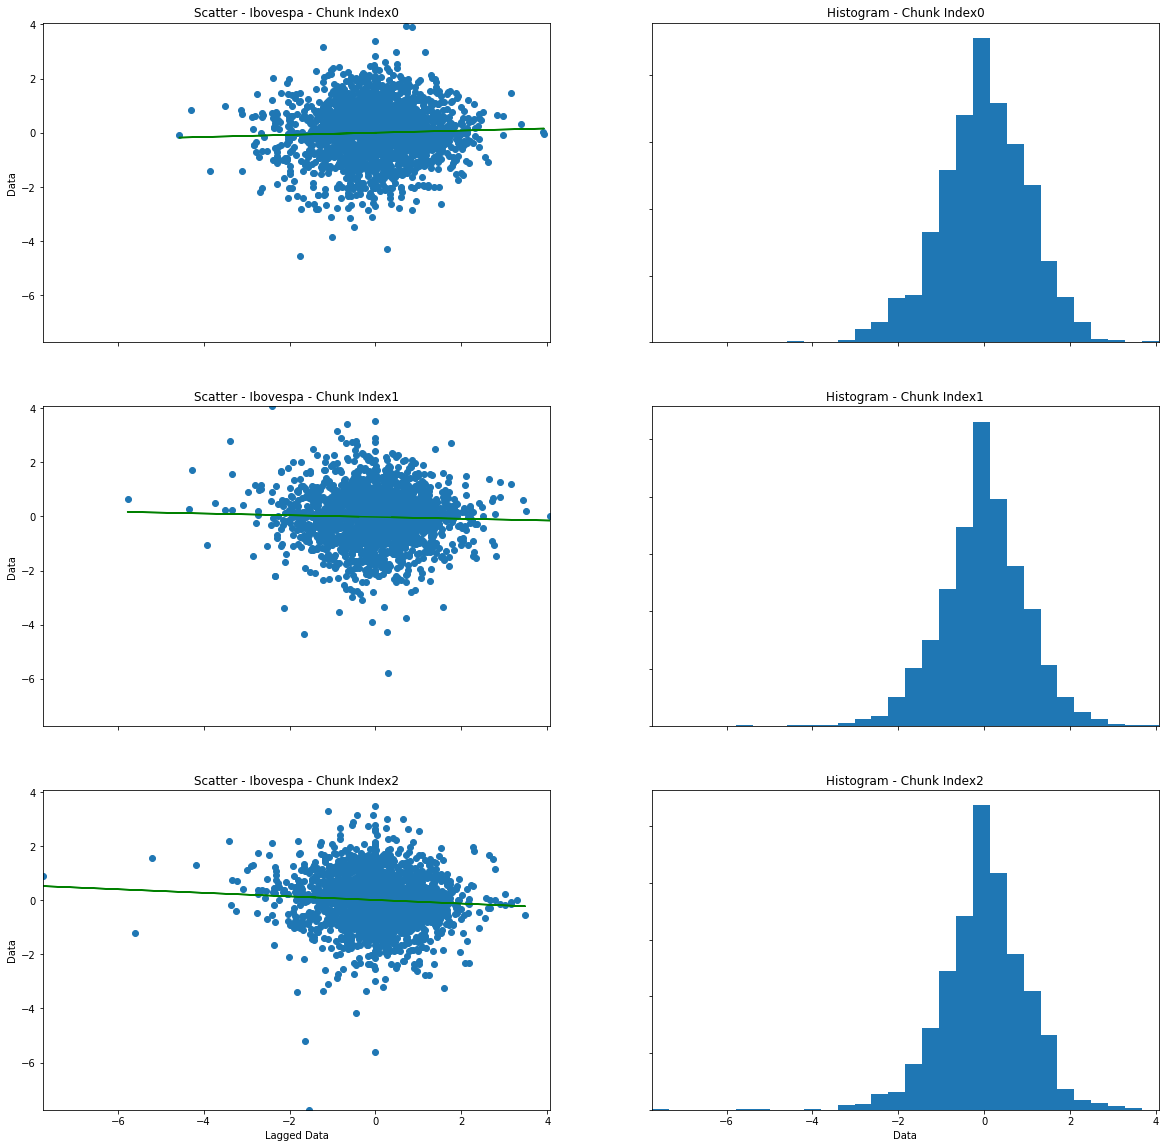

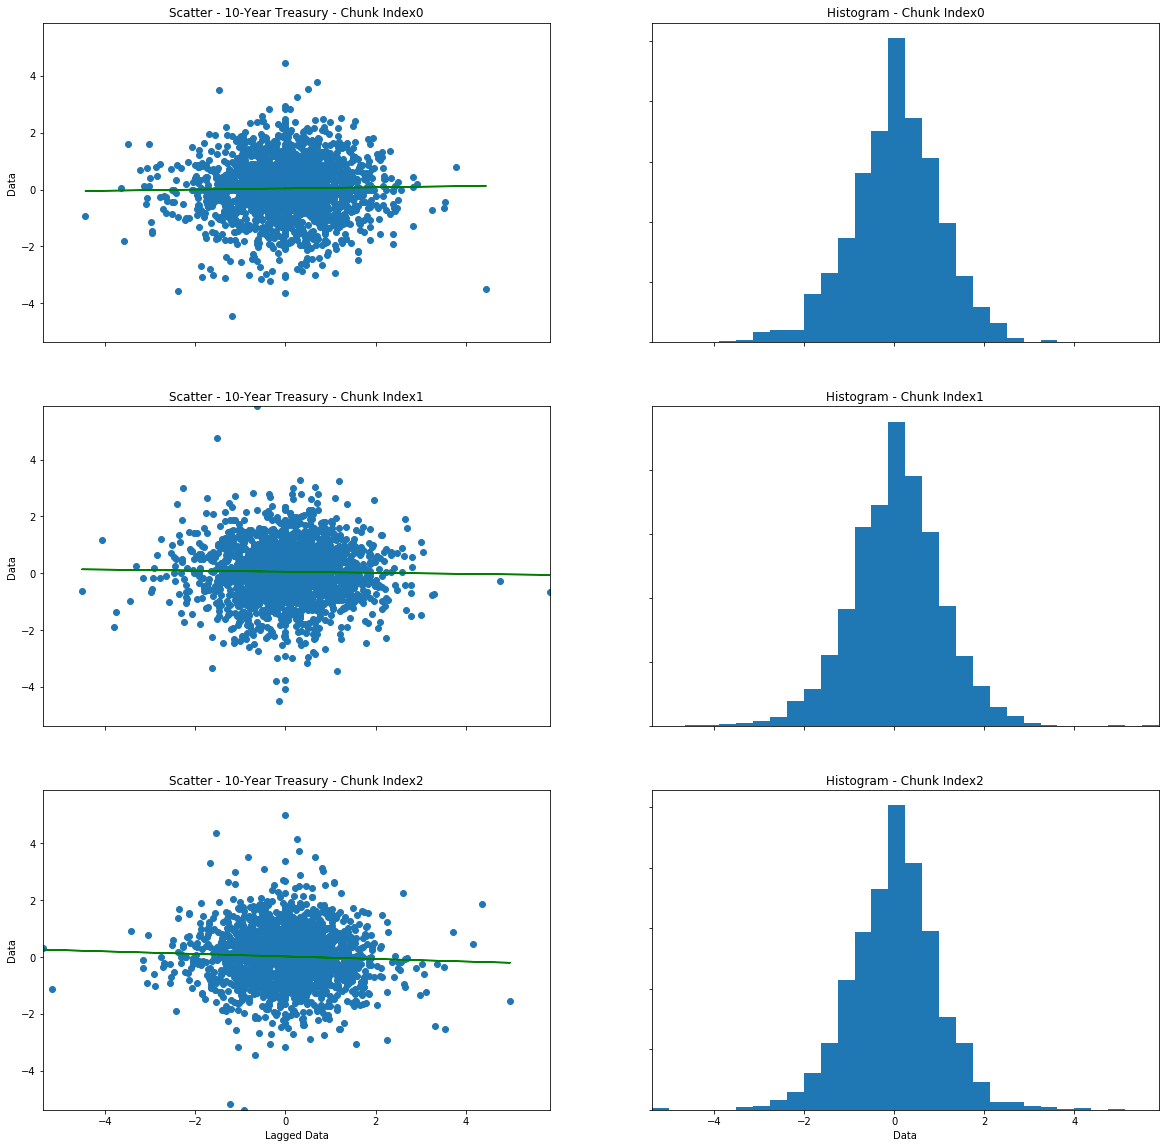

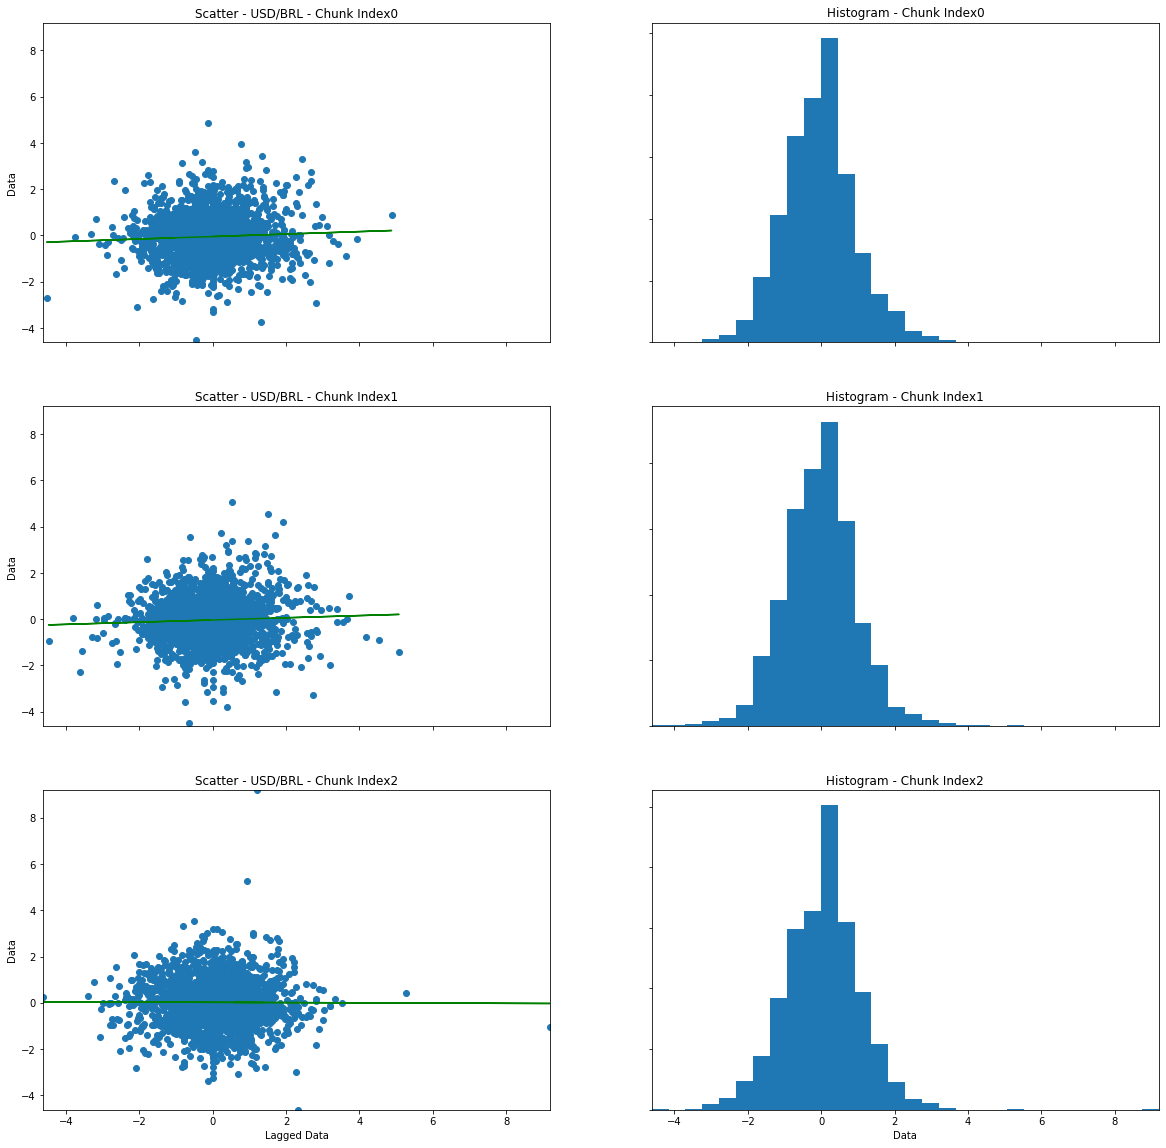

In [7]:
# Quick Invariance Analysis - Of residuals
for item in df_log_resid.columns:
    fig, axs = quick_invariance_analysis(df_log_resid[item], n_chunks=3, nbins=30)
    fig.set_size_inches(20, 20)

In [8]:
# Calculating the pseudo-observations - Estimated Probability Integral Transform
for k, item in enumerate(model_list):
    if k == 0:
        df_log_resid_pseudo_observations = pd.DataFrame(sci.stats.t.cdf(df_log_resid.iloc[:, k], df=model_list[k][1].params.nu))
    else:
        df_log_resid_pseudo_observations = pd.concat([df_log_resid_pseudo_observations, pd.Series(sci.stats.t.cdf(df_log_resid.iloc[:, k], df= np.floor(model_list[k][1].params.nu)))], axis=1, ignore_index=True)

df_log_resid_pseudo_observations.columns = df_log_resid.columns
df_log_resid_pseudo_observations.index=df_log_resid.index

In [9]:
df_log_resid_pseudo_observations.tail(10)

,SP500,Nasdaq100,Ibovespa,10-Year Treasury,USD/BRL
Dates,,,,,
2022-02-09,0.846860,0.827721,0.549316,0.658184,0.155543
2022-02-10,0.113758,0.149871,0.750998,0.021840,0.626014
2022-02-11,0.103008,0.084210,0.542068,0.894299,0.449704
2022-02-14,0.409854,0.515373,0.604800,0.194269,0.364536
2022-02-15,0.850769,0.860956,0.777653,0.293958,0.177269
2022-02-16,0.533019,0.488257,0.578766,0.568855,0.176852
2022-02-17,0.080401,0.091536,0.099287,0.903740,0.720459
2022-02-18,0.323541,0.298141,0.289395,0.707515,0.193527
2022-02-21,0.500000,0.500000,0.182594,0.500000,0.165626


In [10]:
# Empirical Copula Plotting
fig1 =  px.scatter_matrix(data_frame=df_log_resid_pseudo_observations,
                          dimensions=df_log_resid_pseudo_observations.columns,
                          height=2000, width=2000)
fig1.update_traces(marker=dict(size=4, line=dict(width=1)), opacity=0.6, showlegend=False)
#fig1.update_traces(diagonal_visible=False)
fig1.update_layout(plot_bgcolor = "#ffebe3", colorway = ["#ff774a"], title = "Empirical Copula")
fig1.update_layout({"yaxis"+str(i+1): dict(range = [0, 1]) for i in range(1, len(df.columns))})
fig1.update_layout({"xaxis"+str(i+1): dict(range = [0, 1]) for i in range(1, len(df.columns))})
fig1.update_xaxes(visible=True, showgrid=True)
fig1.update_yaxes(visible=True, showgrid=True)
fig1.write_html("HTML/file.html")
#fig1.show()

In [ ]:
# Meta Distribution - Distribution which is constructed by an arbitrary copula and arbitrary marginal distributions

In [11]:
# Creating Vine - Structure
copVine = pv.Vinecop(d = df_log_resid_pseudo_observations.columns.shape[0])

# Selecting Most Appropriate Model Given pseudo-observations
copVine.select(data=df_log_resid_pseudo_observations)

In [12]:
# Simulating U - Given Vine - Empirical X Simulated Copulas
n_sim = 10000
u_sim = pd.DataFrame(copVine.simulate(n_sim, seeds=seeds), columns=df_log_resid_pseudo_observations.columns)

In [13]:
# Plotting simulation results given Vine
fig2 =  px.scatter_matrix(data_frame=u_sim,
                          dimensions=u_sim.columns,
                          height=2000, width=2000)
fig2.update_traces(marker=dict(size=4, line=dict(width=1)), opacity=0.6, showlegend=False)
#fig1.update_traces(diagonal_visible=False)
fig2.update_layout(plot_bgcolor = "#ffebe3", colorway = ["#ff774a"], title = "Simulated Data - Given Vine Structure")
fig2.update_layout({"yaxis"+str(i+1): dict(range = [0, 1]) for i in range(1, len(df.columns))})
fig2.update_layout({"xaxis"+str(i+1): dict(range = [0, 1]) for i in range(1, len(df.columns))})
fig2.update_xaxes(visible=True, showgrid=True)
fig2.update_yaxes(visible=True, showgrid=True)
fig2.write_html("HTML/simulated.html")

In [14]:
# Scenario Simulation
scenarios = list()

for k in range(1):
    scenario = dict()
    scenario['u_sim'] = pd.DataFrame(copVine.simulate(n_os), columns=df_log_resid_pseudo_observations.columns)

    scenarios.append(scenario)














In [15]:
scenario['u_sim']

,SP500,Nasdaq100,Ibovespa,10-Year Treasury,USD/BRL
0,0.438195,0.371214,0.134845,0.309837,0.800111
1,0.973933,0.984354,0.351391,0.107684,0.824393
2,0.885903,0.660120,0.940658,0.090989,0.097398
3,0.223006,0.136180,0.242641,0.310531,0.876813
4,0.781876,0.360742,0.522848,0.430740,0.284546
...,...,...,...,...,...
247,0.895824,0.872451,0.862790,0.057802,0.614662
248,0.946543,0.959877,0.876758,0.453797,0.607058
249,0.942491,0.821986,0.854381,0.285658,0.026463
250,0.319925,0.362098,0.420438,0.756451,0.592062


In [20]:
model.params


omega       0.014015
alpha[1]    0.129960
beta[1]     0.870040
nu          5.350029
Name: params, dtype: float64

array([-0.16314348,  2.48791268,  1.36048405, -0.82226984,  0.84112827,
        0.43053104,  1.95879951,  0.74136672,  1.25279496,  1.59190729,
        1.39877978,  0.25390233, -0.43322416,  1.17484966,  0.01873194,
       -0.17792775, -2.55569118,  1.11939422,  0.2053147 , -0.37514281,
       -0.9555171 ,  1.04265368, -0.72149145,  1.57053214, -1.22231469,
       -0.12267309, -0.90741602,  2.1469385 , -1.35400334,  2.86450906,
        0.53918134,  1.2579763 ,  2.08367198,  1.55128221, -2.30968334,
        0.47546435, -1.16250399, -0.0054795 ,  0.6033352 ,  0.61326347,
       -2.75000826, -2.47781226, -0.02847735,  1.3435275 ,  1.81433019,
       -1.13037438,  0.95119645, -0.37467729, -0.07372608,  0.7854453 ,
       -0.38310413,  0.7921291 ,  0.76749244, -0.2114625 ,  0.27993463,
       -0.7553563 , -1.0693094 ,  1.84801737, -1.26161522, -1.61735118,
       -0.7934326 ,  0.26343924, -1.43750225, -2.57226279,  2.2151976 ,
        1.55059122,  0.46142416,  0.54394767, -1.42531413, -0.36

In [24]:
zero_mean_garch_1_1_scenario(sci.stats.t.ppf(scenario['u_sim'].iloc[:, 0], df=model.params.nu, loc=0, scale=1),
                             model.conditional_volatility,
                             model.resid, model.params.omega,
                             model.params['alpha[1]'],
                             model.params['beta[1]'])

KeyboardInterrupt: 

In [ ]:
model.params['alpha[1]']

In [ ]:
df_log_ret.iloc[1:-n_os, k].tail(10)

In [ ]:
def

https://www.oreilly.com/library/view/bayesian-statistics-an/9781118359778/OEBPS/c1-sec1-0007.htm

In [ ]:
# Invariance Analysis
fig1 =  px.scatter_matrix(data_frame=df_log_ret.iloc[1:, :],
                          dimensions=df_log_ret.columns[1:],
                          height=4000, width=4000,
                          symbol="sample", color="sample")
fig1.update_traces(marker=dict(size=4, line=dict(width=1)), opacity=0.6, showlegend=False)
#fig1.update_traces(diagonal_visible=False)
fig1.update_layout(plot_bgcolor = "#ffebe3", colorway = ["#ff774a"], title = "Scatter plots")
fig1.update_layout({"yaxis"+str(i+1): dict(range = [-0.15, 0.15]) for i in range(1, len(df.columns))})
fig1.update_layout({"xaxis"+str(i+1): dict(range = [-0.15, 0.15]) for i in range(1, len(df.columns))})
fig1.update_xaxes(visible=True, showgrid=True)
fig1.update_yaxes(visible=True, showgrid=True)
fig1.write_html("HTML/file.html")

fig1.show()